In [1]:
import psycopg2
import pandas as pd
from datetime import datetime, timedelta

exposures = psycopg2.connect('service=exposure')
department_id = 78503
start_date = (datetime.utcnow() - timedelta(days=30))

def plot_multi(data, cols=None, spacing=.1, **kwargs):

    from pandas import plotting

    # Get default color style from pandas - can be changed to any other color list
    if cols is None: cols = data.columns
    if len(cols) == 0: return
    colors = getattr(getattr(plotting, '_matplotlib').style, '_get_standard_colors')(num_colors=len(cols))

    # First axis
    ax = data.loc[:, cols[0]].plot(label=cols[0], color=colors[0], **kwargs)
    ax.set_ylabel(ylabel=cols[0])
    lines, labels = ax.get_legend_handles_labels()

    for n in range(1, len(cols)):
        # Multiple y-axes
        ax_new = ax.twinx()
        ax_new.spines['right'].set_position(('axes', 1 + spacing * (n - 1)))
        data.loc[:, cols[n]].plot(ax=ax_new, label=cols[n], color=colors[n % len(colors)], **kwargs)
        ax_new.set_ylabel(ylabel=cols[n])

        # Proper legend position
        line, label = ax_new.get_legend_handles_labels()
        lines += line
        labels += label

    ax.legend(lines, labels, loc=0)
    return ax

In [2]:
incidents = pd.read_sql_query(f'SELECT _id, incident_number, created_at FROM "Incidents" WHERE department_id = {department_id} AND created_at > \'{start_date}\'', exposures)
incidents = incidents.set_index('_id')
incidents.drop_duplicates(subset ='incident_number', 
                     keep = False, inplace = True) 

incidents = incidents.created_at.dt.floor('d')\
       .value_counts().to_frame()
incidents.rename(columns={'created_at': 'incidents'}, inplace=True)
incidents.sort_index(inplace=True)


In [3]:
incidents['incidents'] = incidents.iloc[:].rolling(window=3).mean()
incidents

,incidents
2020-06-13 00:00:00+00:00,NaN
2020-06-14 00:00:00+00:00,NaN
2020-06-16 00:00:00+00:00,113.666667
2020-06-17 00:00:00+00:00,829.000000
2020-06-18 00:00:00+00:00,873.000000
2020-06-19 00:00:00+00:00,961.333333
2020-06-20 00:00:00+00:00,311.333333
2020-06-21 00:00:00+00:00,363.000000
2020-06-22 00:00:00+00:00,314.000000
2020-06-23 00:00:00+00:00,304.666667


In [37]:
exposures_df = pd.read_sql_query(f'SELECT created_at, ems."emsGlovesWorn", ems."emsEyeProtection", ems."emsMask", ems."emsFluidResistantClothing" FROM "Exposures" e FULL OUTER JOIN "EMSExposures" ems ON ems.exposure_id = e._id WHERE department_id = {department_id} AND "exposureType" = \'EMS\' AND created_at > \'{start_date}\'', exposures)
exposures_df.created_at = pd.to_datetime(exposures_df.created_at)
exposures_df.set_index('created_at')
exposures_df.replace(False, 0, inplace=True)
exposures_df.replace(True, 1, inplace=True)
exposures_df.dropna(how='any', inplace=True)
exposures_df


,created_at,emsGlovesWorn,emsEyeProtection,emsMask,emsFluidResistantClothing
0,2020-06-17 07:55:16.023964+00:00,1.0,0.0,1.0,0.0
1,2020-06-17 08:09:44.668171+00:00,1.0,0.0,1.0,0.0
2,2020-06-17 07:55:59.412701+00:00,1.0,0.0,1.0,0.0
3,2020-06-13 22:52:13.405905+00:00,1.0,1.0,1.0,1.0
4,2020-06-14 20:50:31.844406+00:00,1.0,0.0,1.0,0.0
...,...,...,...,...,...
64,2020-07-11 19:37:29.784885+00:00,1.0,1.0,1.0,1.0
65,2020-07-12 02:37:31.899994+00:00,1.0,1.0,1.0,0.0
66,2020-07-13 14:14:30.247613+00:00,1.0,1.0,1.0,0.0
67,2020-07-13 15:16:05.970210+00:00,1.0,1.0,1.0,0.0


In [54]:
ems_cols = [col for col in exposures_df.columns if 'ems' in col]

agg_params = {col: 'sum' for col in ems_cols}

_exposures_df = exposures_df.groupby(pd.Grouper(key='created_at', freq='1d')).agg(agg_params)

for col in ems_cols:
    _exposures_df[col] = _exposures_df[col].iloc[:].rolling(window=3).mean()

_exposures_df

,emsGlovesWorn,emsEyeProtection,emsMask,emsFluidResistantClothing
created_at,,,,
2020-06-13 00:00:00+00:00,NaN,NaN,NaN,NaN
2020-06-14 00:00:00+00:00,NaN,NaN,NaN,NaN
2020-06-15 00:00:00+00:00,1.000000,0.333333,1.000000,0.333333
2020-06-16 00:00:00+00:00,0.666667,0.000000,0.666667,0.000000
2020-06-17 00:00:00+00:00,2.333333,1.333333,2.333333,1.333333
2020-06-18 00:00:00+00:00,3.000000,2.000000,3.000000,1.666667
2020-06-19 00:00:00+00:00,3.333333,2.333333,3.000000,2.000000
2020-06-20 00:00:00+00:00,1.333333,1.333333,1.000000,1.000000
2020-06-21 00:00:00+00:00,1.333333,1.333333,1.000000,1.000000


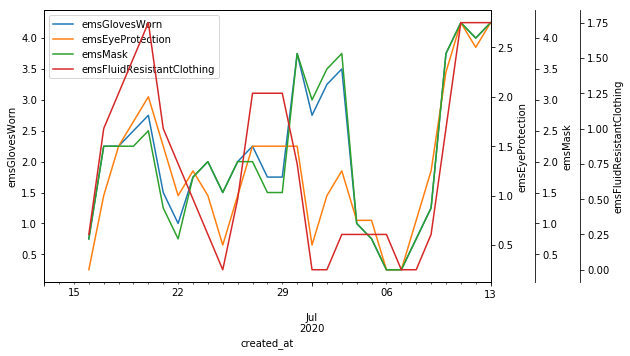

In [53]:
plot_multi(_exposures_df, figsize=(8, 5))